In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)        # Show all rows
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.width', None)           # Disable line wrapping
pd.set_option('display.max_colwidth', None)    # Show full column content (especially for strings)

def load_and_sort_csv(path):
    df = pd.read_csv(
        path,
        parse_dates=['Date'],
        index_col='Date',
        date_format='%d/%m/%y'
    )

    df.index = pd.to_datetime(df.index)
    return df
path = '../data/final/dataset2.csv'

In [3]:
df = load_and_sort_csv(path)

df['Oil_Crude_Price'] = df['Oil_Crude_Price'].clip(lower=0)

X = df.drop(columns=['btc_close'], axis=1)
y = df['btc_close']

## Handling Missing data

In [16]:
# Log return
y_log = np.log(y).diff().dropna()

In [ ]:
# def invert_log_return_prediction(y_hat, scaler: StandardScaler, y_prev: float):
#     """
#     Convert predicted standardized log returns back to actual prices.

#     Parameters:
#     - y_hat: array-like, predicted standardized log returns
#     - scaler: fitted StandardScaler used on original log returns
#     - y_prev: float, last known actual price before prediction starts

#     Returns:
#     - np.ndarray of predicted actual prices
#     """
#     # Step 1: Invert standardization (z -> log return)
#     log_returns = scaler.inverse_transform(np.array(y_hat).reshape(-1, 1)).flatten()

#     # Step 2: Recover log prices
#     log_y0 = np.log(y_prev)
#     log_prices = np.cumsum(np.insert(log_returns, 0, log_y0))

#     # Step 3: Convert log prices to actual prices
#     prices = np.exp(log_prices)

#     # Exclude the first value which corresponds to y_prev
#     return prices[1:]

# y_hat = [0.2, -0.1, 0.05]

# y_pred = invert_log_return_prediction(y_hat, scaler, y.iloc[0])

# y_pred

# check skewness

In [ ]:
# already_normalized_grp = ['PiCycle_cbbi', 'RUPL_cbbi', 'RHODL_cbbi', 'Puell_cbbi', '2YMA_cbbi',
#        'Trolololo_cbbi', 'MVRV_cbbi', 'ReserveRisk_cbbi', 'Woobull_cbbi',
#        'Confidence_cbbi']

In [19]:
X_copy = X.copy()

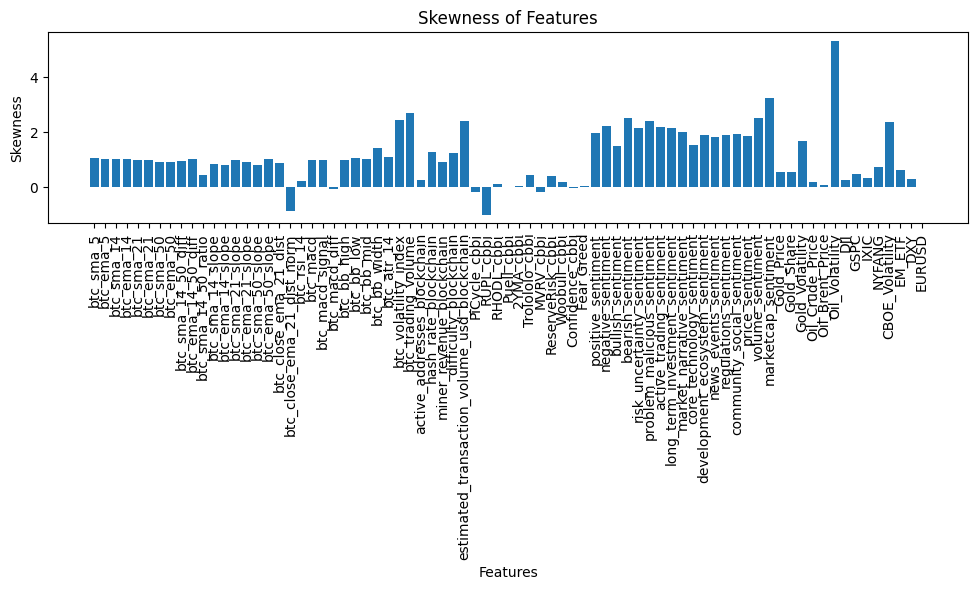

In [20]:
skew_values = [X_copy[col].skew() for col in X_copy.columns]
# # print skew value along with col name
# for col, skew in zip(X_copy.columns, skew_values):
#   print(f"Column: '{col}' - Skewness: {skew:.4f}")
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(X_copy.columns, skew_values)
plt.title('Skewness of Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [23]:
for col in X_copy.columns:
    if (X_copy[col] < 0).any():
        print(f"Column '{col}' contains negative values")


Column 'btc_sma_14_50_diff' contains negative values
Column 'btc_ema_14_50_diff' contains negative values
Column 'btc_sma_14_slope' contains negative values
Column 'btc_ema_14_slope' contains negative values
Column 'btc_sma_21_slope' contains negative values
Column 'btc_ema_21_slope' contains negative values
Column 'btc_sma_50_slope' contains negative values
Column 'btc_ema_50_slope' contains negative values
Column 'btc_close_ema_21_dist' contains negative values
Column 'btc_close_ema_21_dist_norm' contains negative values
Column 'btc_macd' contains negative values
Column 'btc_macd_signal' contains negative values
Column 'btc_macd_diff' contains negative values


In [26]:
X_train.columns

Index(['btc_sma_5', 'btc_ema_5', 'btc_sma_14', 'btc_ema_14', 'btc_sma_21',
       'btc_ema_21', 'btc_sma_50', 'btc_ema_50', 'btc_sma_14_50_diff',
       'btc_ema_14_50_diff', 'btc_sma_14_50_ratio', 'btc_sma_14_slope',
       'btc_ema_14_slope', 'btc_sma_21_slope', 'btc_ema_21_slope',
       'btc_sma_50_slope', 'btc_ema_50_slope', 'btc_close_ema_21_dist',
       'btc_close_ema_21_dist_norm', 'btc_rsi_14', 'btc_macd',
       'btc_macd_signal', 'btc_macd_diff', 'btc_bb_high', 'btc_bb_low',
       'btc_bb_mid', 'btc_bb_width', 'btc_atr_14', 'btc_volatility_index',
       'btc_trading_volume', 'active_addresses_blockchain',
       'hash_rate_blockchain', 'miner_revenue_blockchain',
       'difficulty_blockchain', 'estimated_transaction_volume_usd_blockchain',
       'PiCycle_cbbi', 'RUPL_cbbi', 'RHODL_cbbi', 'Puell_cbbi', '2YMA_cbbi',
       'Trolololo_cbbi', 'MVRV_cbbi', 'ReserveRisk_cbbi', 'Woobull_cbbi',
       'Confidence_cbbi', 'Fear Greed', 'positive_sentiment',
       'negative_senti

In [27]:
from sklearn.preprocessing import PowerTransformer

# --- 1. Split Data (CRITICAL for Time Series) ---
# IMPORTANT: For actual time series, use a time-based split, not random!
# Example: Splitting the last 20% as test set
train_size = int(len(X) * 0.8)
X_train = X.iloc[:train_size].copy()
X_test = X.iloc[train_size:].copy()
# Or use sklearn's TimeSeriesSplit for cross-validation

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}\n")

# --- 2. Identify Transformations and Fit on TRAINING data ---
transformers = {} # Dictionary to store fitted transformers or method names

print("--- Fitting Transformations on Training Data ---")
X_train_transformed = X_train.copy() # Create a copy to store transformed train data

for col in X_train.columns:
    skew = X_train[col].skew()
    print(f"Column '{col}': Original skew={skew:.4f}")

    # Skip approximately symmetric
    if -0.5 <= skew <= 0.5:
        print("  -> Symmetric, skipping transformation.")
        transformers[col] = None # Or 'passthrough'
        continue

    # Positive Skew
    if skew > 0.5:
        # Decide between Box-Cox (requires all > 0) and Yeo-Johnson
        if X_train[col].min() > 0:
            print("  -> Fitting Box-Cox (positive skew, all positive)")
            pt = PowerTransformer(method='box-cox', standardize=False)
            # Reshape for fit_transform: needs 2D array
            X_train_transformed[col] = pt.fit_transform(X_train[[col]]).flatten()
            transformers[col] = pt # Store the fitted object
        else:
            # Use Yeo-Johnson if min <= 0 (robust for non-positive)
            print("  -> Fitting Yeo-Johnson (positive skew, contains non-positive)")
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            X_train_transformed[col] = pt.fit_transform(X_train[[col]]).flatten()
            transformers[col] = pt # Store the fitted object

    # Negative Skew (skew < -0.5) - Remains the same
    elif skew < -0.5: # Use elif now since the positive skew block is unified
        print("  -> Fitting Yeo-Johnson (negative skew)")
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        X_train_transformed[col] = pt.fit_transform(X_train[[col]]).flatten()
        transformers[col] = pt # Store the fitted object

    # (Keep the final print statement for new skew)
    # Check new skewness on the transformed training data
    if transformers.get(col) is not None and isinstance(transformers.get(col), PowerTransformer): # Check it's not None
        new_skew = pd.Series(X_train_transformed[col]).skew() # Use pd.Series to get skew method
        print(f"  New skew (train): {new_skew:.4f}")
    print("-" * 20)

# --- 3. Apply Saved Transformations to Test Data ---
print("\n--- Applying Transformations to Test Data ---")
X_test_transformed = X_test.copy() # Create a copy for transformed test data

for col in X_test.columns:
    transformer = transformers.get(col) # Get the saved transformer/method

    if transformer is None:
        print(f"Column '{col}': No transformation needed.")
        continue
    elif isinstance(transformer, PowerTransformer):
        method = transformer.method
        print(f"Column '{col}': Applying fitted {method}")

        # Get the current column from X_test (it's a DataFrame with one column)
        current_test_column_df = X_test[[col]]

        if method == 'box-cox' and current_test_column_df[col].min() <= 0:
            original_min_val = current_test_column_df[col].min()
            print(f"  WARNING: Column '{col}' was Box-Cox transformed (trained on strictly positive data), "
                  f"but current test data for this column contains non-positive values (min={original_min_val:.4f}).")
            print(f"  Clipping values to a small positive (1e-9) before applying Box-Cox transformation to prevent error.")

            # Create a copy of the column DataFrame to modify it safely
            data_to_transform = current_test_column_df.copy()
            data_to_transform[col] = np.maximum(data_to_transform[col], 1e-9)
            
            X_test_transformed[col] = transformer.transform(data_to_transform).flatten()
        else:
            # If not Box-Cox, or if Box-Cox and data is already strictly positive, transform directly
            X_test_transformed[col] = transformer.transform(current_test_column_df).flatten()
    else:
         print(f"Column '{col}': Unknown transformer type '{transformer}'") # Should not happen

    # Optional: Check skewness on transformed test data
    new_skew_test = pd.Series(X_test_transformed[col]).skew()
    print(f"  New skew (test): {new_skew_test:.4f}")
    print("-" * 20)


print("\n--- Transformation Process Complete ---")
print("Original Training Data Head:")
print(X_train.head())
print("\nTransformed Training Data Head:")
print(X_train_transformed.head())
print("\nOriginal Test Data Head:")
print(X_test.head())
print("\nTransformed Test Data Head:")
print(X_test_transformed.head())
print("\nStored Transformers:")
print(transformers)

Train shape: (2337, 77), Test shape: (585, 77)

--- Fitting Transformations on Training Data ---
Column 'btc_sma_5': Original skew=1.1408
  -> Fitting Box-Cox (positive skew, all positive)
  New skew (train): -0.0320
--------------------
Column 'btc_ema_5': Original skew=1.1377
  -> Fitting Box-Cox (positive skew, all positive)
  New skew (train): -0.0321
--------------------
Column 'btc_sma_14': Original skew=1.1331
  -> Fitting Box-Cox (positive skew, all positive)
  New skew (train): -0.0326
--------------------
Column 'btc_ema_14': Original skew=1.1243
  -> Fitting Box-Cox (positive skew, all positive)
  New skew (train): -0.0329
--------------------
Column 'btc_sma_21': Original skew=1.1273
  -> Fitting Box-Cox (positive skew, all positive)
  New skew (train): -0.0332
--------------------
Column 'btc_ema_21': Original skew=1.1138
  -> Fitting Box-Cox (positive skew, all positive)
  New skew (train): -0.0335
--------------------
Column 'btc_sma_50': Original skew=1.1046
  -> Fittin

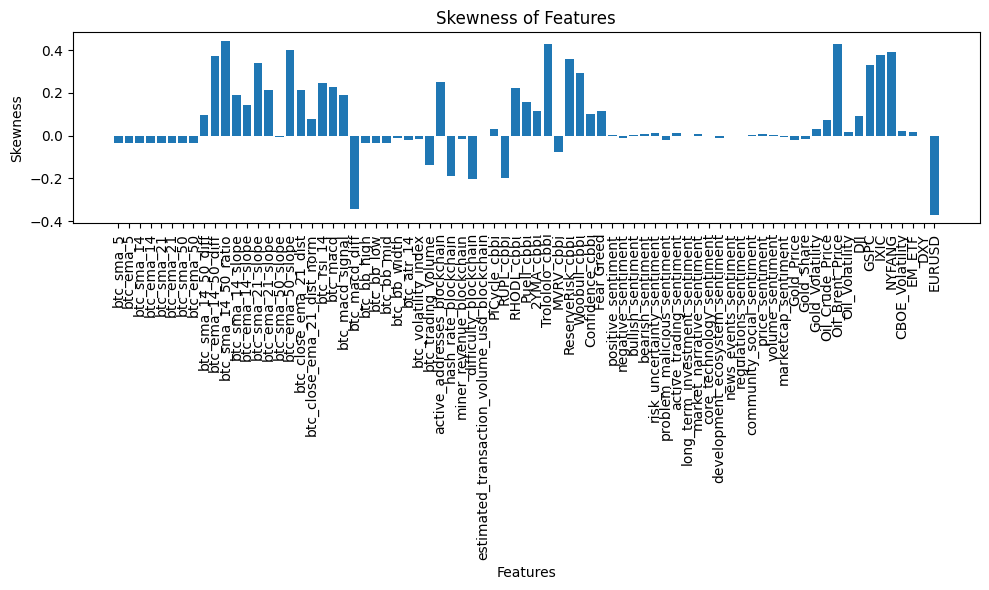

In [30]:
skew_values = [X_train_transformed[col].skew() for col in X_train_transformed.columns]
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(X_train_transformed.columns, skew_values)
plt.title('Skewness of Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# prompt: concat X_copy and y_series to form new df
y_series.name = 'btc_close'
# Concatenate X_copy and y_series
df = pd.concat([X_copy, y_series], axis=1)
df = new_df.dropna()

In [ ]:
# new_df.to_csv("/content/drive/MyDrive/Main Sharing 1/TMA/Data/processed_dataset.csv", index=True)

In [10]:
df.head()

,btc_sma_5,btc_ema_5,btc_sma_14,btc_ema_14,btc_sma_21,btc_ema_21,btc_sma_50,btc_ema_50,btc_sma_14_50_diff,btc_ema_14_50_diff,btc_sma_14_50_ratio,btc_sma_14_slope,btc_ema_14_slope,btc_sma_21_slope,btc_ema_21_slope,btc_sma_50_slope,btc_ema_50_slope,btc_close_ema_21_dist,btc_close_ema_21_dist_norm,btc_rsi_14,btc_macd,btc_macd_signal,btc_macd_diff,btc_bb_high,btc_bb_low,btc_bb_mid,btc_bb_width,btc_atr_14,btc_volatility_index,btc_trading_volume,active_addresses_blockchain,hash_rate_blockchain,miner_revenue_blockchain,difficulty_blockchain,estimated_transaction_volume_usd_blockchain,PiCycle_cbbi,RUPL_cbbi,RHODL_cbbi,Puell_cbbi,2YMA_cbbi,Trolololo_cbbi,MVRV_cbbi,ReserveRisk_cbbi,Woobull_cbbi,Confidence_cbbi,Fear Greed,positive_sentiment,negative_sentiment,bullish_sentiment,bearish_sentiment,risk_uncertainty_sentiment,problem_malicious_sentiment,active_trading_sentiment,long_term_investment_sentiment,market_narrative_sentiment,core_technology_sentiment,development_ecosystem_sentiment,news_events_sentiment,regulations_sentiment,community_social_sentiment,price_sentiment,volume_sentiment,marketcap_sentiment,Gold_Price,Gold_Share,Gold_Volatility,Oil_Crude_Price,Oil_Brent_Price,Oil_Volatility,DJI,GSPC,IXIC,NYFANG,CBOE_Volatility,EM_ETF,DXY,EURUSD,btc_close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,974.544800,968.763975,908.780853,917.957205,867.114761,888.108727,798.158420,816.719767,110.622433,100.983404,1.138597,67.634927,60.643935,48.409854,53.226265,26.052079,35.013269,110.216286,0.110401,85.061012,53.447164,46.015756,10.465832,1027.196256,715.736044,871.466150,35.739795,24.732607,44.381042,147775008.0,355325,2463610.662,1970085.325,3.176880e+11,166788994.4,0.5909,0.8431,0.4559,0.4440,0.4951,0.0033,0.6056,0.2475,0.4111,0.4552,0,222.4,114.428571,113,41,48.4,33.571429,79.000,197.625,13.0,60.750,95.363636,49.625,45.6,20.2,867,38,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,998.325012
2017-01-02,983.710596,986.425984,925.140568,931.796244,878.622524,900.257933,804.552800,824.760168,120.587768,106.815914,1.149882,70.106070,58.668608,50.022903,52.553785,27.124999,35.437414,121.492067,0.118906,86.779600,56.965028,48.769272,11.014066,1046.419181,720.632516,883.525848,36.873473,25.443705,34.687988,222184992.0,529709,2526780.166,2138666.021,3.176880e+11,279981138.0,0.5924,0.8511,0.4570,0.4576,0.5011,0.0111,0.6086,0.2500,0.4173,0.4607,0,281.2,173.142857,124,59,60.2,54.428571,108.500,258.750,20.0,94.625,143.636364,65.625,62.8,32.8,1203,58,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052698,1021.750000
2017-01-03,997.779187,1005.563978,942.495139,946.735407,891.159854,913.310845,811.329180,833.351533,131.165959,113.193067,1.161668,73.502856,60.225187,52.908471,54.170982,28.896898,36.806259,130.529120,0.125047,88.162557,60.834177,51.705628,11.745422,1066.653823,726.633768,896.643796,37.921419,25.232011,22.479980,185168000.0,515024,2589949.671,2245225.092,3.176880e+11,341754284.9,0.5941,0.8555,0.4655,0.4740,0.5132,0.0269,0.6195,0.2602,0.4302,0.4710,70,268.4,175.428571,87,65,60.6,62.571429,90.375,251.375,16.2,99.000,155.454545,74.250,85.4,28.4,955,32,47,1160.400024,110.470001,16.26,52.330002,55.470001,32.880001,19881.75977,2257.830078,5429.080078,1416.569946,12.85,29.630316,103.209999,1.046003,1043.839966
2017-01-04,1036.477588,1055.285979,965.384351,974.468017,908.933614,935.258039,820.191399,845.954609,145.192953,128.348041,1.177023,83.796997,77.994096,61.708708,66.836530,32.845038,42.950798,219.471941,0.190063,92.438640,72.018222,56.253993,18.193459,1110.400030,720.551758,915.475894,42.584220,31.685444,115.020020,344945984.0,545609,2432025.910,2332472.035,3.176880e+11,433678086.9,0.5959,0.8584,0.4725,0.4826,0.5167,0.0315,0.6448,0.2670,0.4334,0.4781,70,357.8,237.000000,201,86,79.2,74.142857,159.875,357.000,31.2,130.000,183.909091,102.375,111.8,40.8,1612,70,93,1163.800049,110.860001,15.16,53.259998,56.459999,32.360001,19942.16016,2270.750000,5477.000000,1441.150024,11.85,2

In [41]:
# Check and print columns that contain zero values or NaN values
zero_columns = []
nan_columns = []

for column in df.columns:
    # Check for zeros
    zero_count = (df[column] == 0).sum()
    if zero_count > 0:
        print(f"Column '{column}' has {zero_count} zero values")
        zero_columns.append(column)
    
    # Check for NaNs
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column '{column}' has {nan_count} NaN values")
        nan_columns.append(column)

if not zero_columns and not nan_columns:
    print("No columns contain zero values or NaN values")

print("\nSummary:")
print(f"Total columns with zeros: {len(zero_columns)}")
print(f"Total columns with NaNs: {len(nan_columns)}")

No columns contain zero values or NaN values

Summary:
Total columns with zeros: 0
Total columns with NaNs: 0


In [13]:
print(f"Number of rows in the DataFrame: {len(df)}")

Number of rows in the DataFrame: 2922


In [4]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# --- The Main Imputation Function (Unchanged from before) ---

def robust_time_series_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs a robust, multi-step imputation on a time series DataFrame
    with a corrected, more logical order of operations.

    The strategy is ordered from most to least sophisticated:
    1. Use a multivariate imputer (IterativeImputer) as the primary method to
       fill gaps by leveraging inter-variable correlations.
    2. Apply time-based interpolation to fill any gaps the model might have missed.
    3. Use a simple forward/backward fill as a final, robust cleanup step to
       guarantee no NaNs remain, especially at the edges.

    Args:
        df (pd.DataFrame): The input DataFrame with a DatetimeIndex and
                           columns containing missing values (NaNs).

    Returns:
        pd.DataFrame: A fully imputed DataFrame with the same shape as the input.
    """
    print("Starting robust time series imputation with corrected logic...")

    if df.isnull().sum().sum() == 0:
        print("No missing values detected. Returning original dataframe.")
        return df

    original_index = df.index
    original_columns = df.columns
    df_imputed = df.copy()

    # --- Step 1 (Primary): Multivariate Imputation with IterativeImputer ---
    # This is now the FIRST step. It's the most sophisticated model, using relationships
    # between columns to make intelligent imputations for all types of gaps.
    print("\nStep 1: Performing multivariate imputation with IterativeImputer...")
    nans_before_iterative = df_imputed.isnull().sum().sum()

    imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=42,
        initial_strategy='mean',
        imputation_order='ascending'
    )

    imputed_data = imputer.fit_transform(df_imputed)
    df_imputed = pd.DataFrame(imputed_data, index=original_index, columns=original_columns)
    print(f"   > Filled {nans_before_iterative - df_imputed.isnull().sum().sum()} NaNs using variable correlations.")

    if df_imputed.isnull().sum().sum() == 0:
        print("Imputation complete after Step 1.")
        return df_imputed

    # --- Step 2 (Secondary): Univariate Time Series Interpolation ---
    # This handles any gaps that IterativeImputer may have missed, for example,
    # if an entire row was NaN, giving the imputer no features to work from.
    # Polynomial interpolation can capture non-linear trends.
    print("\nStep 2: Applying polynomial interpolation for any remaining gaps...")
    nans_before_interp = df_imputed.isnull().sum().sum()
    df_imputed = df_imputed.interpolate(method='polynomial', order=2, limit_direction='both')
    print(f"   > Filled {nans_before_interp - df_imputed.isnull().sum().sum()} NaNs via interpolation.")

    # --- Step 3 (Final Cleanup): Forward and Backward Fill ---
    # This is now the LAST resort. Its aggressive fill is safe here, as it only
    # cleans up any stubborn NaNs left at the absolute edges of the dataset
    # by the more advanced methods.
    if df_imputed.isnull().sum().sum() > 0:
        print("\nStep 3: Performing final ffill/bfill cleanup for edges...")
        nans_before_fallback = df_imputed.isnull().sum().sum()
        df_imputed = df_imputed.ffill().bfill()
        print(f"   > Filled {nans_before_fallback} remaining NaNs.")

    print("\nImputation complete. Final check for missing values:")
    print(f"Total NaNs in final DataFrame: {df_imputed.isnull().sum().sum()}")
    return df_imputed


# --- Main Application Script with New Pre-processing Steps ---

# Load the dataset
df = load_and_sort_csv(path)

print("\nInitial state of DataFrame with missing values (showing sums):")
print("Note: Zeros are not yet counted as missing.")
print(df.isnull().sum())
print("-" * 50)


# --- THE IMPROVED WORKFLOW ---

# Step 1 (NEW): Convert meaningful zeros to NaNs
# This tells the imputation functions to treat them as missing.
print("\nWORKFLOW STEP 1: Converting meaningful zeros to NaN...")
for col in df.columns:
    df[col] = df[col].replace(0, np.nan)
print("NaN counts after converting zeros:")
print(df.isnull().sum())
print("-" * 50)


# Step 2 (NEW): Handle systematic weekend gaps with forward fill
# This is the most logical way to fill data for markets closed on weekends.
print("\nWORKFLOW STEP 2: Forward-filling weekend gaps in cross-market data...")
cbbi_columns = [
    "PiCycle_cbbi",
    "RUPL_cbbi",
    "RHODL_cbbi",
    "Puell_cbbi",
    "2YMA_cbbi",
    "Trolololo_cbbi",
    "MVRV_cbbi",
    "ReserveRisk_cbbi",
    "Woobull_cbbi",
    "Confidence_cbbi"
]

cols_other_than_cbbi = [col for col in df.columns if col not in cbbi_columns + ['btc_close']]

df[cols_other_than_cbbi] = df[cols_other_than_cbbi].interpolate(method='time').bfill().ffill()
print("NaN counts after forward-filling weekends:")
print(df.isnull().sum())
print("-" * 50)

# Step 3 (EXISTING): Run the robust imputation function for any remaining NaNs
# This will now handle the converted sentiment zeros and the random gaps in 'close_price'.
print("\nWORKFLOW STEP 3: Running robust imputation for all remaining complex gaps...")
df_imputed_final = robust_time_series_imputation(df[cbbi_columns])

# Update the CBBI columns in the main DataFrame with the imputed values
df[cbbi_columns] = df_imputed_final

print(f"\nTotal NaNs in final DataFrame: {df.isnull().sum().sum()}")
print("-" * 50)


Initial state of DataFrame with missing values (showing sums):
Note: Zeros are not yet counted as missing.
btc_sma_5                                        0
btc_ema_5                                        0
btc_sma_14                                       0
btc_ema_14                                       0
btc_sma_21                                       0
btc_ema_21                                       0
btc_sma_50                                       0
btc_ema_50                                       0
btc_sma_14_50_diff                               0
btc_ema_14_50_diff                               0
btc_sma_14_50_ratio                              0
btc_sma_14_slope                                 0
btc_ema_14_slope                                 0
btc_sma_21_slope                                 0
btc_ema_21_slope                                 0
btc_sma_50_slope                                 0
btc_ema_50_slope                                 0
btc_close_ema_21_dist    

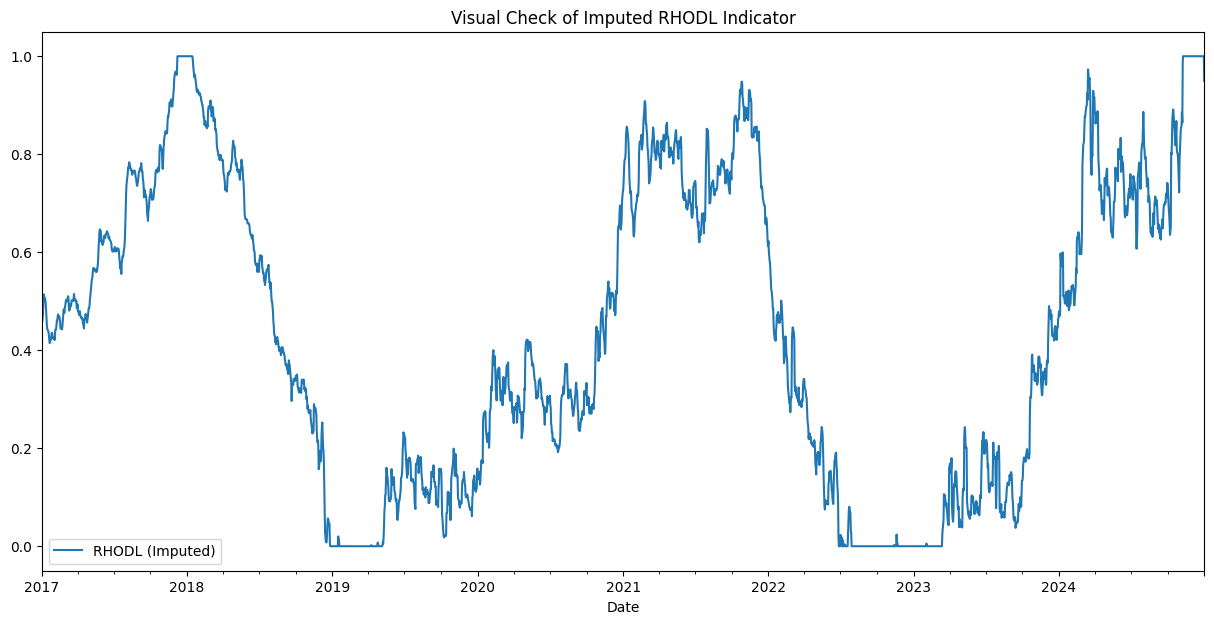

In [ ]:
import matplotlib.pyplot as plt

# After running the full imputation...
fig, ax = plt.subplots(figsize=(15, 7))
df['RHODL_cbbi'].plot(ax=ax, label='RHODL')
ax.set_title('Visual Check of Imputed RHODL Indicator')
ax.legend()
plt.show()

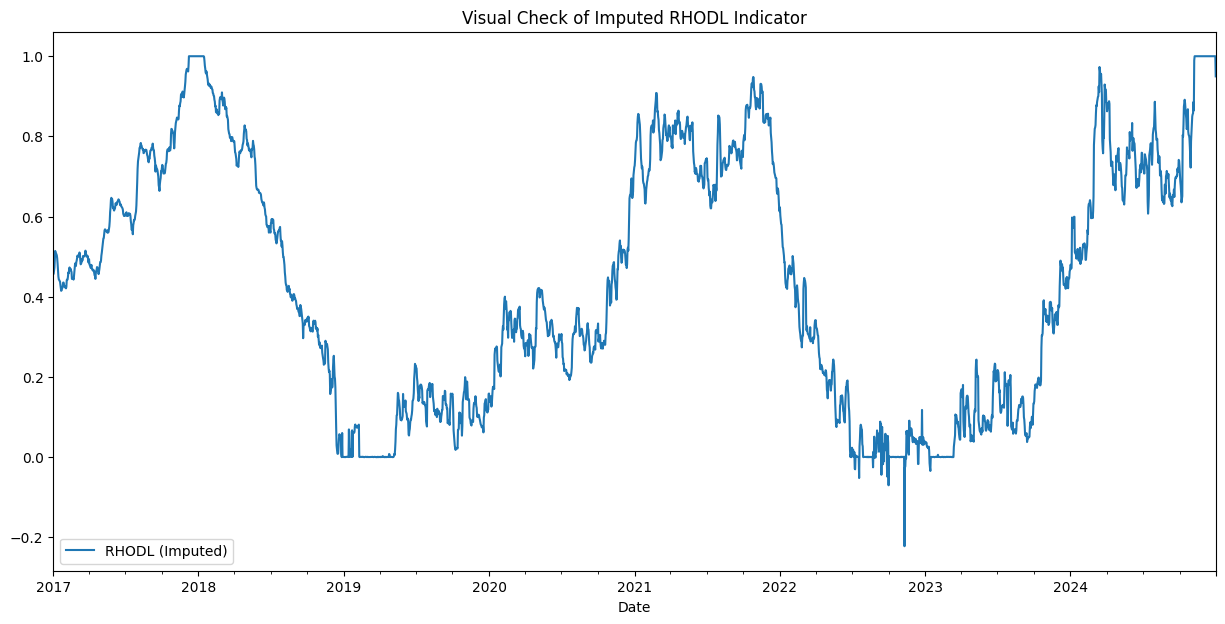

In [4]:
import matplotlib.pyplot as plt

# After running the full imputation...
fig, ax = plt.subplots(figsize=(15, 7))
df['RHODL_cbbi'].plot(ax=ax, label='RHODL (Imputed)')
ax.set_title('Visual Check of Imputed RHODL Indicator')
ax.legend()
plt.show()

In [6]:
df = df.reset_index()

df.head()

,Date,btc_sma_5,btc_ema_5,btc_sma_14,btc_ema_14,btc_sma_21,btc_ema_21,btc_sma_50,btc_ema_50,btc_sma_14_50_diff,btc_ema_14_50_diff,btc_sma_14_50_ratio,btc_sma_14_slope,btc_ema_14_slope,btc_sma_21_slope,btc_ema_21_slope,btc_sma_50_slope,btc_ema_50_slope,btc_close_ema_21_dist,btc_close_ema_21_dist_norm,btc_rsi_14,btc_macd,btc_macd_signal,btc_macd_diff,btc_bb_high,btc_bb_low,btc_bb_mid,btc_bb_width,btc_atr_14,btc_volatility_index,btc_trading_volume,active_addresses_blockchain,hash_rate_blockchain,miner_revenue_blockchain,difficulty_blockchain,estimated_transaction_volume_usd_blockchain,PiCycle_cbbi,RUPL_cbbi,RHODL_cbbi,Puell_cbbi,2YMA_cbbi,Trolololo_cbbi,MVRV_cbbi,ReserveRisk_cbbi,Woobull_cbbi,Confidence_cbbi,Fear Greed,positive_sentiment,negative_sentiment,bullish_sentiment,bearish_sentiment,risk_uncertainty_sentiment,problem_malicious_sentiment,active_trading_sentiment,long_term_investment_sentiment,market_narrative_sentiment,core_technology_sentiment,development_ecosystem_sentiment,news_events_sentiment,regulations_sentiment,community_social_sentiment,price_sentiment,volume_sentiment,marketcap_sentiment,Gold_Price,Gold_Share,Gold_Volatility,Oil_Crude_Price,Oil_Brent_Price,Oil_Volatility,DJI,GSPC,IXIC,NYFANG,CBOE_Volatility,EM_ETF,DXY,EURUSD,btc_close
0,2017-01-01,974.544800,968.763975,908.780853,917.957205,867.114761,888.108727,798.158420,816.719767,110.622433,100.983404,1.138597,67.634927,60.643935,48.409854,53.226265,26.052079,35.013269,110.216286,0.110401,85.061012,53.447164,46.015756,10.465832,1027.196256,715.736044,871.466150,35.739795,24.732607,44.381042,147775008.0,355325,2463610.662,1970085.325,3.176880e+11,166788994.4,0.5909,0.8431,0.4559,0.4440,0.4951,0.0033,0.6056,0.2475,0.4111,0.4552,70.0,222.4,114.428571,113.0,41.0,48.4,33.571429,79.000,197.625,13.0,60.750,95.363636,49.625,45.6,20.2,867.0,38.0,26.0,1156.400024,110.290001,15.68,53.770000,56.139999,30.010000,19819.77930,2249.260010,5432.089844,1423.189941,13.37,29.488140,102.680000,1.057530,998.325012
1,2017-01-02,983.710596,986.425984,925.140568,931.796244,878.622524,900.257933,804.552800,824.760168,120.587768,106.815914,1.149882,70.106070,58.668608,50.022903,52.553785,27.124999,35.437414,121.492067,0.118906,86.779600,56.965028,48.769272,11.014066,1046.419181,720.632516,883.525848,36.873473,25.443705,34.687988,222184992.0,529709,2526780.166,2138666.021,3.176880e+11,279981138.0,0.5924,0.8511,0.4570,0.4576,0.5011,0.0111,0.6086,0.2500,0.4173,0.4607,70.0,281.2,173.142857,124.0,59.0,60.2,54.428571,108.500,258.750,20.0,94.625,143.636364,65.625,62.8,32.8,1203.0,58.0,51.0,1150.000000,109.610001,16.23,53.720001,56.130001,30.830000,19762.59961,2238.830078,5383.120117,1405.060059,14.04,29.279070,102.389999,1.052698,1021.750000
2,2017-01-03,997.779187,1005.563978,942.495139,946.735407,891.159854,913.310845,811.329180,833.351533,131.165959,113.193067,1.161668,73.502856,60.225187,52.908471,54.170982,28.896898,36.806259,130.529120,0.125047,88.162557,60.834177,51.705628,11.745422,1066.653823,726.633768,896.643796,37.921419,25.232011,22.479980,185168000.0,515024,2589949.671,2245225.092,3.176880e+11,341754284.9,0.5941,0.8555,0.4655,0.4740,0.5132,0.0269,0.6195,0.2602,0.4302,0.4710,70.0,268.4,175.428571,87.0,65.0,60.6,62.571429,90.375,251.375,16.2,99.000,155.454545,74.250,85.4,28.4,955.0,32.0,47.0,1160.400024,110.470001,16.26,52.330002,55.470001,32.880001,19881.75977,2257.830078,5429.080078,1416.569946,12.85,29.630316,103.209999,1.046003,1043.839966
3,2017-01-04,1036.477588,1055.285979,965.384351,974.468017,908.933614,935.258039,820.191399,845.954609,145.192953,128.348041,1.177023,83.796997,77.994096,61.708708,66.836530,32.845038,42.950798,219.471941,0.190063,92.438640,72.018222,56.253993,18.193459,1110.400030,720.551758,915.475894,42.584220,31.685444,115.020020,344945984.0,545609,2432025.910,2332472.035,3.176880e+11,433678086.9,0.5959,0.8584,0.4725,0.4826,0.5167,0.0315,0.6448,0.2670,0.4334,0.4781,70.0,357.8,237.000000,201.0,86.0,79.2,74.142857,159.875,357.000,31.2,130.000,183.909091,1

In [7]:
df.to_parquet("dataset.parquet")